In [1]:
import pandas as pd
from scipy import spatial
import numpy as np
import networkx as nx

In [2]:
df = pd.read_excel('online_retail_II.xlsx')

In [3]:
cluster = pd.read_csv('rfm.csv')

In [4]:
df = df.merge(cluster[['Unnamed: 0', 'cluster']], 
         left_on='Customer ID', 
         right_on='Unnamed: 0')

In [5]:
df['Description'] = df.groupby(['StockCode'])['Description'].transform(lambda x: x.fillna(method='bfill'))

In [6]:
df = df[(~df['Invoice'].isna()) & (df['Quantity'] >= 0) & (df['Price'] != 0) & (~df['StockCode'].isin(['AMAZONFEE', 
                                                                            'B',
                                                                            'BANK CHARGES',
                                                                            'D',
                                                                            'SAMPLES',
                                                                             'TEST001',
                                                                             'TEST002',
                                                                             'PADS', 'DOT', 'M',
                                                                             'm','S', 'POST',
                                                                            'Adjustment by john on 26/01/2010 16',
                                                                            'ADJUST2',
                                                                            'ADJUST1',
                                                                            'This is a test product.',
                                                                            'ADJUST']))]

In [15]:
UK_df = df[(df['Country'] == 'United Kingdom') & (df['cluster'].isin([1, 2]))]

In [16]:
UK_df = UK_df[~UK_df['Customer ID'].isna()]
# new_df = new_df.drop(['Unnamed: 0'], axis=1)

In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_df[~new_df['Customer ID'].isna()]['Customer ID'])

In [18]:
train_set = UK_df[UK_df['Customer ID'].isin(train)]
test_set = UK_df[UK_df['Customer ID'].isin(test)]

In [19]:
UK_df = UK_df.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [20]:
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(UK_df, min_support=0.015, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.020867,(12 PENCILS SMALL TUBE SKULL)
1,0.018469,(3 HEARTS HANGING DECORATION RUSTIC)
2,0.016249,(3 STRIPEY MICE FELTCRAFT)
3,0.028592,(6 RIBBONS RUSTIC CHARM)
4,0.017315,(60 CAKE CASES VINTAGE CHRISTMAS)


<AxesSubplot:>

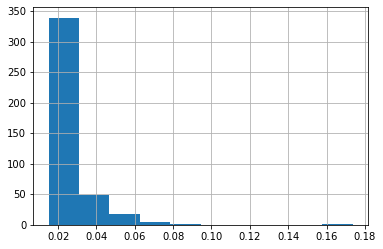

In [23]:
frequent_itemsets['support'].hist()

In [24]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)
# rules = rules.explode('antecedents')


<AxesSubplot:>

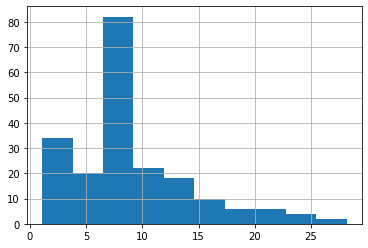

In [27]:
rules['lift'].hist()

In [256]:
rules['antecedents_len'] = rules['antecedents'].map(lambda x: len(x))

In [257]:
rules[rules['confidence'] <= 0.8].sort_values('confidence').tail(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len
173,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.052300,0.064909,0.036938,0.706282,10.881185,0.033544,3.183635,1
181,"(WOODEN FRAME ANTIQUE WHITE , WOOD S/3 CABINET...",(WOOD 2 DRAWER CABINET WHITE FINISH),0.023086,0.038004,0.016693,0.723077,19.026384,0.015816,3.473875,2
199,"(WOODEN FRAME ANTIQUE WHITE , WOOD S/3 CABINET...",(WOODEN PICTURE FRAME WHITE FINISH),0.023086,0.052300,0.016871,0.730769,13.972705,0.015663,3.520029,2
32,(EDWARDIAN PARASOL RED),(EDWARDIAN PARASOL BLACK),0.020955,0.030279,0.015361,0.733051,24.210025,0.014727,3.632606,1
140,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.055496,0.173770,0.040845,0.736000,4.235479,0.031202,3.129658,1
175,"(WHITE HANGING HEART T-LIGHT HOLDER, WOODEN PI...",(WOODEN FRAME ANTIQUE WHITE ),0.026105,0.064909,0.019357,0.741497,11.423714,0.017663,3.617327,2
146,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.043776,0.070236,0.033209,0.758621,10.800994,0.030134,3.851879,1
19,(TOILET METAL SIGN),(BATHROOM METAL SIGN),0.025839,0.032410,0.019624,0.759450,23.432679,0.018786,4.022410,1
91,(LARGE POPCORN HOLDER ),(SMALL POPCORN HOLDER),0.020689,0.034896,0.015805,0.763948,21.892081,0.015083,4.088531,1
186,"(WOOD 2 DRAWER CABINET WHITE FINISH, WOODEN PI...",(WOOD S/3 CABINET ANT WHITE FINISH),0.020067,0.044397,0.015717,0.783186,17.640478,0.014826,4.407475,2


In [258]:
rules[rules.explode('antecedents').reset_index()['antecedents'].isin(test_set['Description'].unique())]

C:\Users\atill\AppData\Local\Temp/ipykernel_11132/1801888890.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rules[rules.explode('antecedents').reset_index()['antecedents'].isin(test_set['Description'].unique())]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len
0,(72 SWEETHEART FAIRY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.035251,0.059137,0.018292,0.518892,8.774412,0.016207,1.955616,1
1,(60 TEATIME FAIRY CAKE CASES),(72 SWEETHEART FAIRY CAKE CASES),0.059137,0.035251,0.018292,0.309309,8.774412,0.016207,1.396788,1
2,(60 TEATIME FAIRY CAKE CASES),(PACK OF 60 DINOSAUR CAKE CASES),0.059137,0.028769,0.018292,0.309309,10.751362,0.016590,1.406173,1
3,(PACK OF 60 DINOSAUR CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.028769,0.059137,0.018292,0.635802,10.751362,0.016590,2.583387,1
4,(PACK OF 60 PINK PAISLEY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.047682,0.059137,0.023974,0.502793,8.502189,0.021155,1.892298,1
...,...,...,...,...,...,...,...,...,...,...
199,"(WOODEN FRAME ANTIQUE WHITE , WOOD S/3 CABINET...",(WOODEN PICTURE FRAME WHITE FINISH),0.023086,0.052300,0.016871,0.730769,13.972705,0.015663,3.520029,2
200,"(WOODEN PICTURE FRAME WHITE FINISH, WOOD S/3 C...",(WOODEN FRAME ANTIQUE WHITE ),0.019446,0.064909,0.016871,0.867580,13.366190,0.015609,7.061553,2
201,(WOODEN FRAME ANTIQUE WHITE ),"(WOODEN PICTURE FRAME WHITE FINISH, WOOD S/3 C...",0.064909,0.019446,0.016871,0.259918,13.366190,0.015609,1.324926,1
202,(WOODEN PICTURE FRAME WHITE FINISH),"(WOODEN FRAME ANTIQUE WHITE , WOOD S/3 CABINET...",0.052300,0.023086,0.016871,0.322581,13.972705,0.015663,1.442110,1


In [259]:
a = rules['antecedents'].explode()
test_set = test_set[test_set['Description'].isin(a)]

In [8]:
def find_recommended_rules(rules_df, product_id, rec_count=1):
    sorted_rules = rules_df.sort_values("lift", ascending=False)
    recommendation_list = []
#     recommendation_list.append(rules[rules['antecedents'] == product_id]['consequents'].unique())
    for i, product in sorted_rules["antecedents"].items():
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"]))


    return list({item for item_list in recommendation_list for item in item_list})[:rec_count]

user_recommend_prodcut = {}
for user in test_set['Customer ID'].unique():
    print(user)
    flag = True
    while flag:
        stockCode = test_set[test_set['Customer ID'] == user]['Description'].sample(1).iloc[0]
        list_recommend_itens = find_recommended_rules(rules, stockCode, 10)
        if len(list_recommend_itens) > 0:
            flag = False
            user_recommend_prodcut[user] = list_recommend_itens

In [242]:
user_recommend_prodcut

{13085.0: ['BATHROOM METAL SIGN', 'VINTAGE HEADS AND TAILS CARD GAME '],
 13078.0: ['WHITE HANGING HEART T-LIGHT HOLDER'],
 15362.0: ['WOODEN FRAME ANTIQUE WHITE '],
 18102.0: ['JUMBO STORAGE BAG SUKI'],
 18087.0: ['WHITE HANGING HEART T-LIGHT HOLDER',
  'JUMBO STORAGE BAG SUKI',
  'LUNCH BAG PINK RETROSPOT',
  'STRAWBERRY CERAMIC TRINKET BOX',
  'WOODEN PICTURE FRAME WHITE FINISH',
  'JUMBO SHOPPER VINTAGE RED PAISLEY',
  'HEART OF WICKER LARGE',
  'FELTCRAFT BUTTERFLY HEARTS',
  'WOOD S/3 CABINET ANT WHITE FINISH',
  'WOODEN FRAME ANTIQUE WHITE '],
 13635.0: ['WHITE HANGING HEART T-LIGHT HOLDER'],
 14110.0: ['72 SWEETHEART FAIRY CAKE CASES',
  'LUNCH BAG PINK RETROSPOT',
  'JUMBO BAG STRAWBERRY'],
 17519.0: ['JUMBO  BAG BAROQUE BLACK WHITE'],
 13758.0: ['WOODEN FRAME ANTIQUE WHITE '],
 15413.0: ['WHITE HANGING HEART T-LIGHT HOLDER',
  'STRAWBERRY CERAMIC TRINKET BOX',
  'WOOD S/3 CABINET ANT WHITE FINISH'],
 16167.0: ['ASSORTED COLOUR BIRD ORNAMENT',
  'HOT WATER BOTTLE TEA AND SYMPA

In [261]:
accuracy = 0
user_accuracy = []
for user, products in user_recommend_prodcut.items():
    
    user_accuracy.append(100*(len(set(products))/10))

In [262]:
sum(user_accuracy)/len(user_accuracy)

33.21678321678322

In [ ]:
sum(user_accuracy)/len(user_accuracy)

In [ ]:
sum(user_accuracy)/len(user_accuracy)

In [ ]:
100*(accuracy/test_set['Customer ID'].nunique())

In [ ]:
26.930938371012697

# GRAFO WIP

In [289]:
G = nx.Graph()
G.add_nodes_from(a.columns, bipartite = 'Products')
G.add_nodes_from(a.index, bipartite = 'Customers')

In [296]:
tuples_customer_stockcode = train_set[['Customer ID', 'Description']].drop_duplicates().to_records(index=False)

In [297]:
G.add_edges_from(tuples_customer_stockcode)

In [223]:
!pip install apyori

Could not fetch URL https://pypi.org/simple/apyori/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/apyori/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1125)'))) - skipping
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1125)'))) - skipping


ERROR: Could not find a version that satisfies the requirement apyori
ERROR: No matching distribution found for apyori


In [225]:
frequent_itemsets

,support,itemsets
0,0.018462,(10002)
1,0.018462,(15036)
2,0.015385,(16237)
3,0.046154,(20658)
4,0.058462,(20665)
...,...,...
42764,0.012308,"(21094, 21671, 20750, 21680, 22356, 21238, 212..."
42765,0.012308,"(21700, 22472, 21577, 21578, 21232, 22326, 210..."
42766,0.012308,"(22114, 21577, 22314, 21232, 22353, 21429, 215..."
42767,0.012308,"(20674, 20675, 20676, 20677, 21238, 21239, 212..."


In [224]:
frequent_itemsets = apriori(frequent_itemsets, min_support=0.07, use_colnames=True)

ValueError: The allowed values for a DataFrame are True, False, 0, 1. Found value 0.018461538461538463

In [307]:
from collections import defaultdict
def items_shared(G, user_1, user_2):
    user_1_itens = G.neighbors(user_1)
    user_2_itens = G.neighbors(user_2)
        
    return set(user_1_itens).intersection(user_2_itens)

def user_similarity(data, G, user_1, user_2):
    itens_shared = items_shared(G, user_1, user_2)
    return len(itens_shared) / data['Description'].nunique()
    
def most_similar_user(data, G, user_to_compare):
    similarities = defaultdict(list)
    users = data[(~data['Customer ID'].isna()) &
              (data['Customer ID'] != user_to_compare)]['Customer ID'].unique()
    
    for user in users:
        similarities[user_similarity(train_set, G, user_to_compare, user)].append(user)
        
    return similarities

In [244]:
test_set['Customer ID'].unique()

array([12533., 13813., 12471., 12600., 12712., 12709., 12472., 12613.,
       12708., 12609., 12648., 12623., 12649., 12647., 12644., 12531.,
       12703., 12468., 12668., 12711., 12500., 12524., 12665., 12645.,
       12621., 12663., 12474., 13815., 12426., 12497., 12530., 12701.,
       12477., 12662., 12481., 12671., 12516., 12625., 12698., 12580.,
       12632., 12619., 12499., 12705., 12527., 13814., 12633., 12693.,
       12730., 12592., 12480., 12720., 12595., 12476., 12519., 12605.,
       12635., 12652., 12699., 12475., 12601., 12492., 12673., 12738.,
       12427.])

In [256]:
rules.sort_values("lift", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(RED SPOTTY CUP),(RED SPOTTY PLATE ),0.138462,0.089231,0.073846,0.533333,5.977011,0.061491,1.951648
5,(RED SPOTTY PLATE ),(RED SPOTTY CUP),0.089231,0.138462,0.073846,0.827586,5.977011,0.061491,4.996923
2,(RED SPOTTY BOWL),(RED SPOTTY CUP),0.095385,0.138462,0.076923,0.806452,5.824373,0.063716,4.451282
3,(RED SPOTTY CUP),(RED SPOTTY BOWL),0.138462,0.095385,0.076923,0.555556,5.824373,0.063716,2.035385
8,(SAVE THE PLANET COTTON TOTE BAG),(WOODLAND DESIGN COTTON TOTE BAG),0.095385,0.153846,0.073846,0.774194,5.032258,0.059172,3.747253
9,(WOODLAND DESIGN COTTON TOTE BAG),(SAVE THE PLANET COTTON TOTE BAG),0.153846,0.095385,0.073846,0.480000,5.032258,0.059172,1.739645
1,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.138462,0.129231,0.070769,0.511111,3.955026,0.052876,1.781119
0,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.129231,0.138462,0.070769,0.547619,3.955026,0.052876,1.904453
6,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.304615,0.200000,0.156923,0.515152,2.575758,0.096000,1.650000
7,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.200000,0.304615,0.156923,0.784615,2.575758,0.096000,3.228571


In [301]:
train_set

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
579,489526,85049E,SCANDINAVIAN REDS RIBBONS,12,2009-12-01 11:50:00,1.25,12533.0,Germany
580,489526,21976,PACK OF 60 MUSHROOM CAKE CASES,24,2009-12-01 11:50:00,0.55,12533.0,Germany
581,489526,21498,RED SPOTS WRAP,25,2009-12-01 11:50:00,0.42,12533.0,Germany
582,489526,22077,6 RIBBONS RUSTIC CHARM,12,2009-12-01 11:50:00,1.65,12533.0,Germany
583,489526,84946,ANTIQUE SILVER TEA GLASS ETCHED,12,2009-12-01 11:50:00,1.25,12533.0,Germany
...,...,...,...,...,...,...,...,...
522926,537995,22352,LUNCH BOX WITH CUTLERY RETROSPOT,6,2010-12-09 11:39:00,2.55,12712.0,Germany
522927,537995,22550,HOLIDAY FUN LUDO,4,2010-12-09 11:39:00,3.75,12712.0,Germany
522928,537995,82494L,WOODEN FRAME ANTIQUE WHITE,6,2010-12-09 11:39:00,2.95,12712.0,Germany
522929,537995,22788,BROCANTE COAT RACK,2,2010-12-09 11:39:00,9.95,12712.0,Germany


In [308]:
%%time
count_similar = []
for client in train_set['Customer ID'].unique():
    result = most_similar_user(test_set, G, client)
    best_user = result[max(result)][0]

    p=set(train_set[train_set['Customer ID'] == best_user]['Description'])
    o=set(train_set[train_set['Customer ID'] == client]['Description'])
    if len(p.intersection(o)) >= 1:
        print('similar', client, best_user)
    else:
        print('nao similar', client, best_user)
    
    

similar 12533.0 12472.0
similar 13813.0 12472.0
similar 12471.0 12472.0
similar 12600.0 12623.0
similar 12712.0 12472.0
similar 12709.0 12472.0
similar 12472.0 12474.0
similar 12613.0 12472.0
similar 12708.0 12472.0
similar 12609.0 12472.0
similar 12648.0 12472.0
similar 12623.0 12472.0
similar 12649.0 12472.0
similar 12647.0 12472.0
similar 12644.0 12472.0
similar 12531.0 12472.0
similar 12703.0 12474.0
similar 12468.0 12472.0
similar 12668.0 12472.0
similar 12711.0 12472.0
similar 12500.0 12647.0
similar 12524.0 12472.0
similar 12665.0 12668.0
similar 12645.0 12472.0
similar 12621.0 12472.0
similar 12663.0 12668.0
similar 12474.0 12472.0
similar 13815.0 12472.0
similar 12426.0 12668.0
similar 12568.0 12533.0
similar 12497.0 12474.0
similar 12530.0 12472.0
similar 12701.0 12472.0
similar 12477.0 12647.0
similar 12662.0 12472.0
similar 12481.0 12472.0
similar 12671.0 12705.0
similar 12516.0 12472.0
similar 12504.0 12527.0
similar 12625.0 12472.0
similar 12698.0 12472.0
similar 12580.0 

In [ ]:
%%time

for client in df['Customer ID'].sample(1).unique():
    result = most_similar_user(G, client)
    best_user = result[max(result)][0]

    p=set(train[train['Customer ID'] == best_user]['StockCode'])
    o=set(test[test['Customer ID'] == client]['StockCode'])
    if len(p.intersection(o)) >= 1:
        print('similar', client, best_user)
    else:
        print('nao similar', client, best_user)
    
    

In [287]:
user_recommend_prodcut

{12533.0: [],
 13813.0: [],
 12471.0: [],
 12600.0: [],
 12712.0: [],
 12709.0: [],
 12472.0: [],
 12613.0: [],
 12708.0: [],
 12609.0: [],
 12648.0: [],
 12623.0: [],
 12649.0: [],
 12647.0: [],
 12644.0: [],
 12531.0: [],
 12703.0: [],
 12468.0: [],
 12668.0: [],
 12711.0: [],
 12500.0: [],
 12524.0: [],
 12665.0: [],
 12645.0: [],
 12621.0: [],
 12663.0: [],
 12474.0: [],
 13815.0: [],
 12426.0: [],
 12497.0: [],
 12530.0: [],
 12701.0: [],
 12477.0: [],
 12662.0: [],
 12481.0: [],
 12671.0: [],
 12516.0: [],
 12625.0: [],
 12698.0: [],
 12580.0: [],
 12632.0: [],
 12619.0: [],
 12499.0: [],
 12705.0: [],
 12527.0: [],
 13814.0: [],
 12633.0: [],
 12693.0: [],
 12730.0: [],
 12592.0: [],
 12480.0: [],
 12720.0: [],
 12595.0: [],
 12476.0: [],
 12519.0: [],
 12605.0: [],
 12635.0: [],
 12652.0: [],
 12699.0: [],
 12475.0: [],
 12601.0: [],
 12492.0: [],
 12673.0: [],
 12738.0: [],
 12427.0: []}

In [ ]:
df[(df['Customer ID'] == 14911) & (df['StockCode'] == 22349)]

In [ ]:
sequetial_values_of_product = new_df.groupby(['StockCode']).size().reset_index().drop(0, axis=1).reset_index().set_index('StockCode')
sequetial_values_of_product = sequetial_values_of_product.to_dict(orient='dict')['index']

In [ ]:
undirected_graph_matrix = np.zeros((new_df.StockCode.unique().shape[0], new_df.StockCode.unique().shape[0]))

for index, v in a.iterrows():
    not_zero = v[v!=0]
    for i in not_zero.index:
        for j in not_zero.index:
            if i != j:
                first_product = sequetial_values_of_product[i]
                second_product = sequetial_values_of_product[j]

                undirected_graph_matrix[first_product][second_product] = 2
                undirected_graph_matrix[second_product][first_product] = 2

In [22]:
no_products = len(new_df.StockCode.unique())
products_weighted = np.zeros((no_products,no_products))

times_purchased = undirected_graph_matrix.sum(axis = 1)

for i in range(no_products):
    for j in range(no_products):
        if (times_purchased[i]+times_purchased[j]) !=0: #make sure you do not divide with zero
            products_weighted[i,j] = (undirected_graph_matrix[i,j])/(times_purchased [i]+times_purchased [j])

In [23]:
graph = nx.from_numpy_matrix(products_weighted)

In [24]:
description = df[~df['Description'].isna()].drop_duplicates(['StockCode']).\
groupby(['StockCode', 'Description']).size().reset_index().drop(0, axis=1).\
set_index('StockCode').to_dict(orient='dict')

In [25]:
labels = {}
new_sequetial = {v:k for k, v in sequetial_values_of_product.items()}
for node in list(graph):
    labels[node] = description['Description'][new_sequetial[node]]



In [26]:
from community import community_louvain

In [27]:
partition = community_louvain.best_partition(graph,  resolution = 1.5)
values = list(partition.values())

In [28]:
products_communities = pd.DataFrame(labels.values(), columns = ['product_description'])
products_communities['community_id'] = values

In [29]:
merged_df = df.merge(products_communities, left_on='Description', right_on='product_description')

In [31]:
merged_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,product_description,community_id
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,15CM CHRISTMAS GLASS BALL 20 LIGHTS,28
1,489559,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 12:55:00,6.95,17056.0,United Kingdom,15CM CHRISTMAS GLASS BALL 20 LIGHTS,28
2,489576,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,5,2009-12-01 13:38:00,7.95,15984.0,United Kingdom,15CM CHRISTMAS GLASS BALL 20 LIGHTS,28
3,489582,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,2,2009-12-01 13:47:00,7.95,14543.0,United Kingdom,15CM CHRISTMAS GLASS BALL 20 LIGHTS,28
4,489597,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,1,2009-12-01 14:28:00,17.35,NaN,United Kingdom,15CM CHRISTMAS GLASS BALL 20 LIGHTS,28


In [32]:
products_communities.groupby(['community_id']).size().head(20)

community_id
0       8
1      51
2      29
3     249
4      91
5      30
6      76
7     302
8      59
9     223
10      1
11      2
12     77
13     41
14     29
15      9
16     46
17    376
18     53
19     10
dtype: int64

In [33]:
products_communities[products_communities['community_id'] == 21].head(15)

,product_description,community_id
43,SLEEPING CAT ERASERS,21
162,GARDEN PATH SKETCHBOOK,21
322,JAZZ HEARTS ADDRESS BOOK,21
1232,CHRISTMAS CRAFT TREE TOP ANGEL,21
1233,CHRISTMAS CRAFT WHITE FAIRY,21
1357,POCKET BAG BLUE PAISLEY RED SPOT,21
1889,BISCUIT TIN VINTAGE GREEN,21
1948,CALENDAR PAPER CUT DESIGN,21
2189,LOVE HEART POCKET WARMER,21
2777,BLUE HOLE PUNCH,21


In [393]:
new_labels = merged_df[['Description', 'StockCode', 'community_id']].drop_duplicates()

In [395]:
nx.set_node_attributes(graph, new_labels.to_dict(orient='index'))

In [89]:
nodesAt5 = {x:y for x,y in graph.nodes(data=True) if y['community_id'] == 5}
import itertools
nodesAt5 = dict(itertools.islice(nodesAt5.items(), 15))

H=nx.relabel_nodes(graph.subgraph(nodesAt5),new_labels)
nx.write_gexf(H, "products.gexf")

NameError: name 'graph' is not defined